In [2]:
import os
import json
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import jax
import jax.numpy as jnp
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from environment.maze import MetaMaze

jax.device_count(), jax.devices()

2024-03-17 14:59:28.286953: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:280] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(1, [CpuDevice(id=0)])

## Visualize training curves

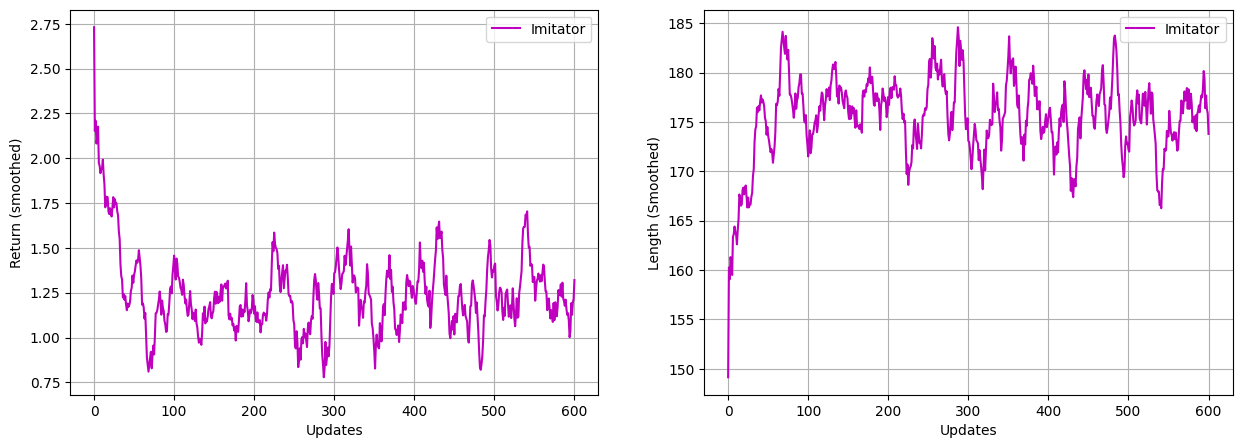

In [15]:
log = 'logs_ppo_bc'
load_path = f'/data/draco/cleain/imitation_gap_minigrid/{log}'
expe_num='20240314_154145'
n_epochs = 1

# log = 'logs_bc_rl'
# load_path = f'/data/draco/cleain/imitation_gap_minigrid/ray_results_20240307/train_2024-03-07_11-09-08/train_209c5_00000_0_WEIGHT_RL=0_2024-03-07_11-09-12/{log}'
# expe_num='20240307_110916'
# n_epochs = 100

with open(os.path.join(load_path, expe_num, 'args.json'), 'r') as file:
    config = json.load(file)

if 'is_expert' in config.keys():
    label = 'Expert' if config['is_expert'] else 'Imitator'
    color = 'b' if config['is_expert'] else 'm'
elif 'full_obs' in config.keys():
    label = 'Expert' if config['full_obs'] else 'Imitator'
    color = 'b' if config['full_obs'] else 'm'

metric_path = os.path.join(load_path, expe_num, f'training_metrics_{n_epochs}.pkl')

import pickle
# Load the data from the pickle file
with open(metric_path, 'rb') as f:
    out = pickle.load(f)

fig = plt.figure(figsize=(15, 5))
window_size = 10

# out = out[0]['eval']

fig.add_subplot(1,2,1)
smoothed_return = jnp.convolve(out['r'].reshape(-1),
                               jnp.ones(window_size) / window_size,
                               mode='valid')

plt.plot(smoothed_return, label=label, c=color)
plt.xlabel("Updates")
plt.ylabel("Return (smoothed)")
plt.legend()
plt.grid('on')

smoothed_length = jnp.convolve(out['l'].reshape(-1),
                               jnp.ones(window_size) / window_size,
                               mode='valid')

fig.add_subplot(1,2,2)
plt.plot(smoothed_length, label=label, c=color)
plt.xlabel("Updates")
plt.ylabel("Length (Smoothed)")
plt.grid('on')
plt.legend();


## Visualize learned policy

In [13]:
from IPython.display import clear_output
from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.pyplot as plt
from PIL import Image
import pickle

In [10]:
from model.rnn_policy import ScannedRNN, ActorCriticRNN
import json

expe_num = '20240308_125508'
log = 'logs_bc_rl'
epochs = '0'

with open(f'/data/draco/cleain/imitation_gap_minigrid/{log}/{expe_num}/args.json', 'r') as file:
    config = json.load(file)

with open(f'/data/draco/cleain/imitation_gap_minigrid/{log}/{expe_num}/params_{epochs}.pkl', 'rb') as file:
    params = pickle.load(file)

In [11]:
def plot_grid_on_image(axe, img, grid_size=(10, 10)):

    # Define grid parameters
    rows, cols = img.shape[:2]

    # Plot vertical grid lines
    for i in range(1, rows + 1):
        axe.axvline(x=1 * i - 0.5, color='gray', linewidth=0.5)

    # Plot horizontal grid lines
    for j in range(1, cols + 1):
        axe.axhline(y=1 * j - 0.55, color='gray', linewidth=0.5)

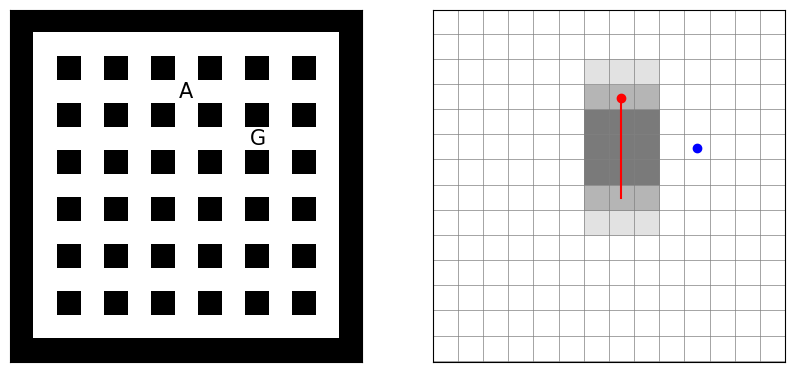

KeyboardInterrupt: 

In [15]:
tt = 0
imgs = []

import numpy as np
occupancy = np.zeros((14, 14))
all_pos = []

rng = jax.random.PRNGKey(7)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

env = MetaMaze(**config['params'])
env_params = env.default_params

network = ActorCriticRNN(env.action_space(env_params).n)

obs, env_state = env.reset(key_reset, env_params)
done = False
hstate = ScannedRNN.initialize_carry((1, 128))

while not done and tt < 200:

    all_pos.append(env_state.pos)
    occupancy[env_state.pos[0] - env.rf_off : env_state.pos[0] + env.rf_off + 1,
              env_state.pos[1] - env.rf_off : env_state.pos[1] + env.rf_off + 1] += 1

    # occupancy[env_state.pos[0],
            #   env_state.pos[1]] += 1

    # fig, ax = env.render(env_state, env_params)
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    ax[0].imshow(env.occupied_map, cmap="Greys")
    ax[0].annotate(
        "A",
        fontsize=15,
        xy=(env_state.pos[1], env_state.pos[0]),
        xycoords="data",
        xytext=(env_state.pos[1] - 0.3, env_state.pos[0] + 0.25),
    )
    ax[0].annotate(
        "G",
        fontsize=15,
        xy=(env_state.goal[1], env_state.goal[0]),
        xycoords="data",
        xytext=(env_state.goal[1] - 0.3, env_state.goal[0] + 0.25),
    )
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # fig.add_subplot(1,2,2)
    ax[1].imshow(occupancy, vmin=0, vmax=5, cmap="Greys")
    plot_grid_on_image(ax[1], occupancy)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    if len(all_pos) > 0:
        ax[1].plot(jnp.array(all_pos)[:, 1], jnp.array(all_pos)[:, 0], c='r')
    ax[1].scatter(all_pos[-1][1], all_pos[-1][0], c='r')
    ax[1].scatter(env_state.goal[1], env_state.goal[0], c='b')

    plt.show()

    rng, _rng = jax.random.split(rng)

    # SELECT ACTION
    ac_in = (obs[jnp.newaxis,jnp.newaxis, :], jnp.array([done])[jnp.newaxis,jnp.newaxis, :])
    hstate, pi, value = network.apply(params, hstate, ac_in)
    action = pi.sample(seed=_rng)
    log_prob = pi.log_prob(action)
    value, action, log_prob = (
        value.squeeze(0),
        action.squeeze(0),
        log_prob.squeeze(0),
    )

    # STEP ENV
    rng, _rng = jax.random.split(rng)

    # Update the environment
    _, env_state, reward, done, info = env.step(_rng, env_state, action[0], env_params)

    # Get the observation
    # obs = env.get_obs(env_state, env_params, config['is_expert'])
    obs = env.get_obs(env_state, env_params, False)

    tt += 1
    
    canvas = FigureCanvasAgg(fig)
    canvas.draw()

    # Get the image buffer as a PIL image
    pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
    imgs.append(pil_image)

    clear_output(wait=True)


In [35]:
# Save gif
gif_file = f"../animation/{expe_num}/ex_{key_reset[0]}.gif"
os.makedirs(f"../animation/{expe_num}", exist_ok=True)

imgs[0].save(gif_file, save_all=True, append_images=imgs, duration=100, loop=0)

## Baselines

In [9]:
expert_expe_num = '20231214_190953'
expert_logs = 'logs_rl'

limited_agent_expe_num = '20231214_192147'
limited_agent_logs = 'logs_rl'

with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', expert_logs, expert_expe_num, 'eval_500.json'), 'r') as file:
    expert_metrics = json.load(file)
expert_mean = jnp.array(expert_metrics['r']).mean()
expert_std = jnp.array(expert_metrics['r']).std()
expert_n = len(expert_metrics['r'])

with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', limited_agent_logs, limited_agent_expe_num, 'eval_500.json'), 'r') as file:
    limited_agent_metrics = json.load(file)
limited_agent_mean = jnp.array(limited_agent_metrics['r']).mean()
limited_agent_std = jnp.array(limited_agent_metrics['r']).std()
limited_agent_n = len(limited_agent_metrics['r'])

In [10]:
jnp.array(limited_agent_metrics['l']).mean()

Array(38.441216, dtype=float32)

In [11]:
def plot_imitator(imitator_expe_num, imitator_logs, imitator_n_epochs, window_size=10):
    with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', imitator_logs, imitator_expe_num, 'args.json'), 'r') as file:
        imitator_config = json.load(file)

    with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', 'logs_rl', imitator_config['expert_expe_num'], 'args.json'), 'r') as file:
        teacher_config = json.load(file)

    with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', imitator_logs, imitator_expe_num, 'eval_500.json'), 'r') as file:
        imitator_eval_metrics = json.load(file)

    with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', imitator_logs, imitator_expe_num, f'training_metrics_{imitator_n_epochs}.pkl'), 'rb') as file:
        imitator_training_metrics = pickle.load(file)

    print(f"Imitator: \n \
        BC from: {imitator_config['expert_expe_num']} \n \
        Has full_obs: {imitator_config['full_obs']} \n \
        Mean length eval: {jnp.array(imitator_eval_metrics['l']).mean():.4f} \n \
        Mean return eval: {jnp.array(imitator_eval_metrics['r']).mean():.4f}")

    if (teacher_config['is_expert'] and imitator_config['full_obs']):
        label = 'Imitator (full obs) from expert (full obs)'
        color = 'darkturquoise'
    elif (teacher_config['is_expert'] and not imitator_config['full_obs']):
        label = 'Imitator (limited obs) from expert (full obs)'
        if 'WEIGHT_BC' in imitator_config.keys():
            color = np.random.randint(0, 255, 3) / 255
            label += f" ($\omega_{{bc}}$={imitator_config['WEIGHT_BC']}, $\omega_{{rl}}$={imitator_config['WEIGHT_RL']})"
        else:
            color = 'orange'
    elif (not teacher_config['is_expert'] and not imitator_config['full_obs']):
        label = 'Imitator (limited obs) from expert (limited obs)'
        color = 'darkred'

    # Imitator performance
    data = [
        imitator_training_metrics[i]['validation']['returned_episode_returns'][
            imitator_training_metrics[i]['validation']['returned_episode']
        ].mean()
        for i in range(imitator_n_epochs)
    ]

    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')  # Example moving average

    plt.plot(smoothed_data, label=label, color=color)


Imitator: 
         BC from: 20231214_190953 
         Has full_obs: True 
         Mean length eval: 6.6178 
         Mean return eval: 9.7472
Imitator: 
         BC from: 20231214_190953 
         Has full_obs: False 
         Mean length eval: 160.6166 
         Mean return eval: 1.9917
Imitator: 
         BC from: 20231214_190953 
         Has full_obs: False 
         Mean length eval: 74.2947 
         Mean return eval: 6.5628


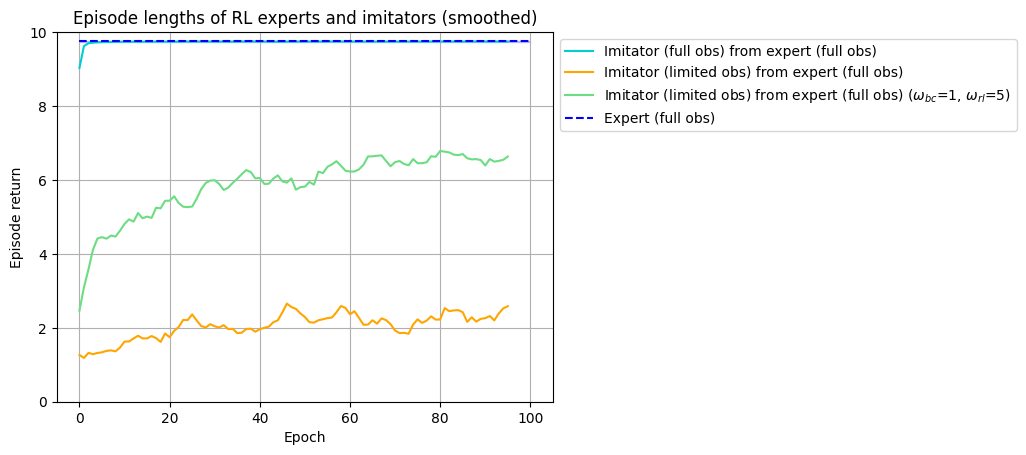

In [21]:
N = 100

# Imitators
# plot_imitator('20231218_103558', 'logs_bc', N, window_size=5)
plot_imitator('20231218_105358', 'logs_bc', N, window_size=5)
plot_imitator('20231218_110732', 'logs_bc', N, window_size=5)
# plot_imitator('20240228_141527', 'logs_bc_rl', N, window_size=5) # w_bc=1 w_rl=10
# plot_imitator('20240228_151205', 'logs_bc_rl', N, window_size=5) # w_bc=0 w_rl=1
# plot_imitator('20240228_144535', 'logs_bc_rl', N, window_size=5) # w_bc=1 w_rl=0
# plot_imitator('20240228_154146', 'logs_bc_rl', N, window_size=5) # w_bc=1 w_rl=15
# plot_imitator('20240228_161908', 'logs_bc_rl', N, window_size=5) # w_bc=1 w_rl=5



# Expert performance
plt.plot([0, N], [expert_mean] * 2, ls='--', label='Expert (full obs)', color='b')
plt.fill_between([0, N], 
                 [expert_mean - 1.96 * expert_std / jnp.sqrt(expert_n)] * 2, 
                 [expert_mean + 1.96 * expert_std / jnp.sqrt(expert_n)] * 2, alpha=0.2, color='b')

# RL agent performance
plt.plot([0, N], [limited_agent_mean] * 2, ls='--', label='Expert (limited obs)', color='m')
plt.fill_between([0, N], 
                 [limited_agent_mean - 1.96 * limited_agent_std / jnp.sqrt(limited_agent_n)] * 2, 
                 [limited_agent_mean + 1.96 * limited_agent_std / jnp.sqrt(limited_agent_n)] * 2, alpha=0.2, color='b')

plt.ylabel('Episode return')
plt.xlabel('Epoch')
plt.title('Episode return of RL experts and imitators (smoothed)00')
plt.ylim(0, 10)

plt.grid('on')
plt.legend(bbox_to_anchor=(1., 1));

## Visualize state visiting map

In [16]:
import pickle
import matplotlib.pyplot as plt

with open('/data/draco/cleain/imitation_gap_minigrid/logs_rl/20231214_190953/visiting_500.pkl', 'rb') as file:
    expert_visiting_state = pickle.load(file)

expert_visiting_state.shape

(15, 15)

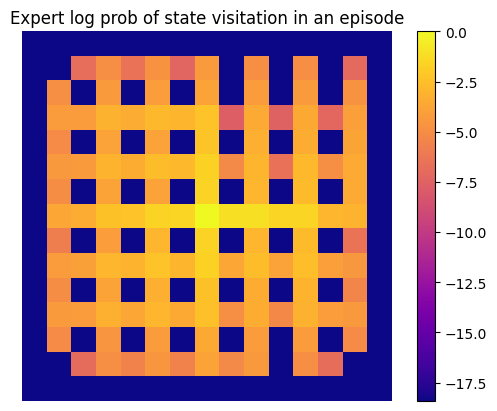

In [17]:
# plt.imshow(1 - env.occupied_map, cmap='gray')
plt.imshow(jnp.log(expert_visiting_state / jnp.max(expert_visiting_state) + 1e-8), cmap='plasma')
plt.colorbar()
plt.title('Expert log prob of state visitation in an episode')
plt.axis('off');

## RAY results

In [3]:
import pandas as pd
import glob

log_folder = '/data/draco/cleain/imitation_gap_minigrid/ray_results_20240314'

train_dfs = []
ii = 0
for training in os.listdir(log_folder):
    for expe in os.listdir(os.path.join(log_folder, training)):
        
        if os.path.isdir(os.path.join(log_folder, training, expe)):
            
            with open(os.path.join(log_folder, training, expe, 'params.json'), 'r') as file:
                params = json.load(file)

            if 'WEIGHT_BC' in params.keys():
                log = 'logs_bc_rl'
            else:
                log = 'logs_bc'
                
            training_metric_path = glob.glob(os.path.join(log_folder, training, expe, log + f"/*/training_metrics_1.pkl"))
            with open(training_metric_path[0], 'rb') as file:
                data = pickle.load(file)
                
            train_df = {}
            
            with open(os.path.join('/data/draco/cleain/imitation_gap_minigrid', 'logs_rl', params['expert_expe_num'], 'args.json'), 'r') as file:
                teacher_config = json.load(file)
                
            if (teacher_config['is_expert'] and params['full_obs']):
                label = 'Imitator (full obs) from expert (full obs)'
                color = 'darkturquoise'
            elif (teacher_config['is_expert'] and not params['full_obs']):
                label = 'Imitator (limited obs) from expert (full obs)'
                if 'WEIGHT_BC' in params.keys():
                    color = np.random.randint(0, 255, 3) / 255
                    label += f" ($\omega_{{bc}}$={params['WEIGHT_BC']}, $\omega_{{rl}}$={params['WEIGHT_RL']})"
                else:
                    color = 'orange'
            elif (not teacher_config['is_expert'] and not params['full_obs']):
                label = 'Imitator (limited obs) from expert (limited obs)'
                color = 'darkred'
                
            train_df['label'] = label
            train_df['seed'] = params['KEY']
            # for timestep, ret in enumerate(data['r']):
            train_df['timestep'] = np.arange(len(data['r']))
            train_df['data'] = data['r'] #item['validation']['returned_episode_returns'][item['validation']['returned_episode']].mean().item()
    
            train_dfs.append(pd.DataFrame(train_df))
                # ii += 1

In [13]:
os.listdir(log_folder)

['train_2024-03-14_15-46-52',
 'train_2024-03-14_17-14-58',
 'train_2024-03-16_15-13-30',
 'train_2024-03-15_10-58-27',
 'train_2024-03-15_08-07-50',
 'train_2024-03-15_09-33-09',
 'train_2024-03-15_06-41-05',
 'train_2024-03-14_23-30-21',
 'train_2024-03-14_20-39-23',
 'train_2024-03-14_22-05-04',
 'train_2024-03-15_03-49-35',
 'train_2024-03-15_05-15-31',
 'train_2024-03-15_00-56-26',
 'train_2024-03-14_19-11-47',
 'train_2024-03-15_02-23-08']

In [4]:
train_df = pd.concat(train_dfs)

In [5]:
train_df

,label,seed,timestep,data
0,Imitator (full obs) from expert (full obs),7,0,7.627001
1,Imitator (full obs) from expert (full obs),7,1,0.755242
2,Imitator (full obs) from expert (full obs),7,2,4.123077
3,Imitator (full obs) from expert (full obs),7,3,1.802687
4,Imitator (full obs) from expert (full obs),7,4,1.438818
...,...,...,...,...
61030,Imitator (limited obs) from expert (full obs) ...,6,61030,8.071586
61031,Imitator (limited obs) from expert (full obs) ...,6,61031,8.026579
61032,Imitator (limited obs) from expert (full obs) ...,6,61032,8.184183
61033,Imitator (limited obs) from expert (full obs) ...,6,61033,8.131782


In [6]:
L2C = {'Imitator (full obs) from expert (full obs)': 'blue',
       'Imitator (limited obs) from expert (limited obs)': 'magenta',
       'Imitator (limited obs) from expert (full obs)': 'orange'
}

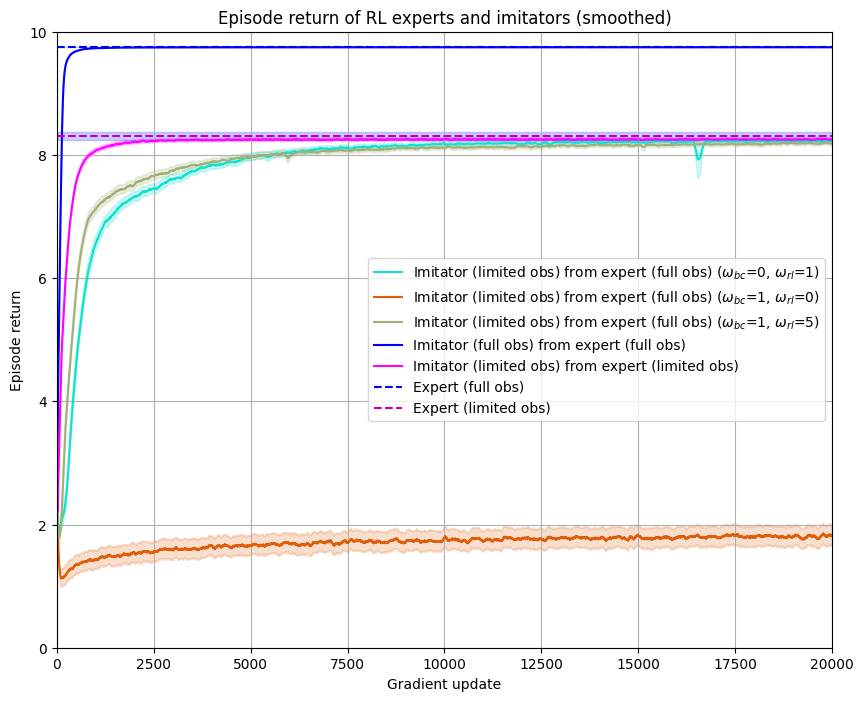

In [21]:

fig, ax = plt.subplots(1, 1, figsize=(10, 8,))
col = 'data'
x = 'timestep'
window = 100

labels = ['Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=0, $\\omega_{rl}$=1)',
          'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=0)',
          
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=1)',
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=2)',
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=3)',
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=4)',
          'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=5)',
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=6)',
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=7)', 
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=8)', 
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=9)', 
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=10)',
        #   'Imitator (limited obs) from expert (full obs) ($\\omega_{bc}$=1, $\\omega_{rl}$=15)',  
          'Imitator (full obs) from expert (full obs)',
          'Imitator (limited obs) from expert (limited obs)']

data = train_df

for label in labels:
    df = data[data.label == label]
    df = df[df[col].isna() == False]
  
    mean = df[df.label == label][[col, x, 'seed']].groupby(['seed']).rolling(window, min_periods=1).mean().groupby([x]).mean().reset_index()
    n_seeds = len(df.seed.unique())
    st_err  = df[df.label == label][[col, x, 'seed']].groupby([x]).std().rolling(window).mean().reset_index() / np.sqrt(n_seeds)
    
    if label in L2C.keys():
        color = L2C[label]
    else:
        color = np.random.randint(0, 255, 3) / 255
        
    line = ax.plot(np.array(mean[x]), mean[col], label=label, color=color) #, linestyle=L2LS[label])
    
    low = mean[col] - st_err[col]
    high = mean[col] + st_err[col]
    
    ax.fill_between(np.array(mean[x]), low, high, alpha=0.2, color=color)
    
    proxy = ax.fill(np.NaN, np.NaN, c=color, alpha=0.2, linewidth=0.0)
    # legend_items.append((line[0], proxy[0]))

N = 20000
# Expert performance
plt.plot([0, N], [expert_mean] * 2, ls='--', label='Expert (full obs)', color='b')
plt.fill_between([0, N], 
                 [expert_mean - 1.96 * expert_std / jnp.sqrt(expert_n)] * 2, 
                 [expert_mean + 1.96 * expert_std / jnp.sqrt(expert_n)] * 2, alpha=0.2, color='b')

# RL agent performance
plt.plot([0, N], [limited_agent_mean] * 2, ls='--', label='Expert (limited obs)', color='m')
plt.fill_between([0, N], 
                 [limited_agent_mean - 1.96 * limited_agent_std / jnp.sqrt(limited_agent_n)] * 2, 
                 [limited_agent_mean + 1.96 * limited_agent_std / jnp.sqrt(limited_agent_n)] * 2, alpha=0.2, color='b')

plt.ylabel('Episode return')
plt.xlabel('Gradient update')
plt.title('Episode return of RL experts and imitators (smoothed)')
plt.ylim(0, 10)
plt.xlim(0, N)
plt.legend()
plt.grid('on');